In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2e17d457-3161-6a5f-a7dc-16ba06665308)


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR

from sklearn.neural_network import MLPRegressor
from scipy.signal import savgol_filter
from scipy.stats import zscore
from sklearn.feature_selection import VarianceThreshold

In [3]:
# Load Dataset
def load_data(file_path):
    df = pd.read_excel(file_path, decimal=',', header=0)
    df.columns = df.columns.astype(str)
    return df

In [29]:
#Detect outliers
def detect_outliers_zscore(df, column, threshold=1.85):
    z_scores = np.abs(zscore(df[column]))
    return df[z_scores > threshold]

In [5]:
# Convert Wavenumbers to Wavelengths
def convert_wavenumbers(df):
    spectral_cols = df.columns[2:]
    try:
        wavenumbers = np.array([float(col.replace(',', '.')) for col in spectral_cols])
        wavelengths = 1e7 / wavenumbers  # Convert cm⁻¹ to nm
        return wavelengths
    except ValueError as e:
        print("Error converting wavenumbers:", e)
        return None

In [6]:
# Preprocessing Functions
def apply_savgol(X, window=17, poly=2, deriv=2):
    return savgol_filter(X, window_length=window, polyorder=poly, deriv=deriv, axis=1)

def apply_snv(X):
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

def apply_msc(X):
    ref = np.mean(X, axis=0)
    return np.array([(spectrum - np.polyfit(ref, spectrum, 1)[1]) / np.polyfit(ref, spectrum, 1)[0] for spectrum in X])

In [7]:
# Feature Selection: Remove Low-Variance Features
def feature_selection(X, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    return selector.fit_transform(X)

In [8]:
# Train ML Models
def train_model(X, y, model, param_grid, cv=5):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
    grid.fit(X, y)

    best_model = grid.best_estimator_
    y_pred = cross_val_predict(best_model, X, y, cv=cv)
    r2, rmse = r2_score(y, y_pred), np.sqrt(mean_squared_error(y, y_pred))

    return best_model, r2, rmse, y_pred

In [24]:
# Load Data
df = load_data('NIR_Data.xlsx')

In [25]:
# Data Head
df.head()

,Sample ID,Unnamed: 1,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture
0,3001RanBioMixMalarenergi.0,1,0.430391,0.430351,0.430570,0.430974,0.431129,0.430807,0.430425,0.430264,...,1.042346,1.052940,1.062511,1.070474,1.077419,1.082571,1.084933,1.086961,1.088756,24.933532
1,3001RanBioMixMalarenergi.1,2,0.418378,0.418387,0.418783,0.418983,0.418721,0.418339,0.417951,0.417494,...,1.017335,1.027128,1.036592,1.043992,1.049032,1.051711,1.052812,1.054065,1.055364,24.933532
2,3001RanBioMixMalarenergi.2,3,0.446782,0.446930,0.446840,0.446419,0.446009,0.445715,0.445539,0.445537,...,1.053265,1.061849,1.070649,1.079960,1.088810,1.094708,1.098719,1.100796,1.099144,24.933532
3,3001RanBioMixMalarenergi.3,4,0.434038,0.433805,0.433692,0.433850,0.433912,0.433757,0.433515,0.433327,...,1.020629,1.029372,1.038613,1.047470,1.053009,1.054695,1.054589,1.053924,1.053708,24.933532
4,3001RanBioMixMalarenergi.4,5,0.451491,0.451441,0.451692,0.451816,0.451755,0.451595,0.451293,0.451114,...,1.013404,1.023107,1.030855,1.036464,1.042622,1.049984,1.055300,1.055122,1.052386,24.933532


In [11]:
# Explore Data
print("Data Description:\n", df.describe())

Data Description:
        Unnamed: 1    11988.51     11980.8    11973.08    11965.37    11957.66  \
count  773.000000  773.000000  773.000000  773.000000  773.000000  773.000000   
mean   408.213454    0.555737    0.555510    0.555277    0.555048    0.554840   
std    248.050920    0.175660    0.175460    0.175265    0.175117    0.174975   
min      1.000000    0.267237    0.267553    0.267540    0.267290    0.267120   
25%    200.000000    0.420672    0.420877    0.421411    0.421568    0.421270   
50%    393.000000    0.499081    0.498969    0.498818    0.498389    0.497959   
75%    598.000000    0.687495    0.687133    0.687137    0.686687    0.685944   
max    949.000000    0.978465    0.977729    0.975623    0.973480    0.972385   

         11949.94    11942.23    11934.51     11926.8  ...    4057.888  \
count  773.000000  773.000000  773.000000  773.000000  ...  773.000000   
mean     0.554626    0.554355    0.554071    0.553910  ...    1.317717   
std      0.174754    0.174469

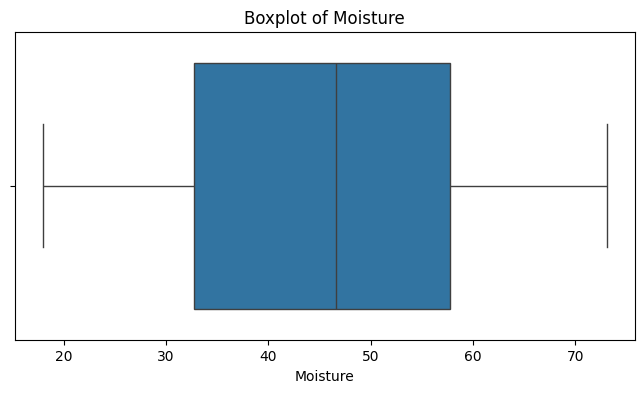

In [15]:
# Visualize Moisture Distribution
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Moisture'])
plt.title("Boxplot of Moisture")
plt.xlabel("Moisture")
plt.show()

In [30]:
# Detect and Print Outliers
outliers = detect_outliers_zscore(df, 'Moisture')
print("Detected Outliers:\n", outliers[['Moisture']])

Detected Outliers:
       Moisture
50   17.981283
51   17.981283
52   17.981283
53   17.981283
54   17.981283
55   17.981283
375  73.066950
376  73.066950
377  73.066950
378  73.066950
379  73.066950
380  73.066950


In [31]:
# Prepare Data
y = df['Moisture'].values
df = df.drop(['Moisture'], axis=1)
wavelengths = convert_wavenumbers(df)
X = df.iloc[:, 2:].values  # Extract spectral absorbance data

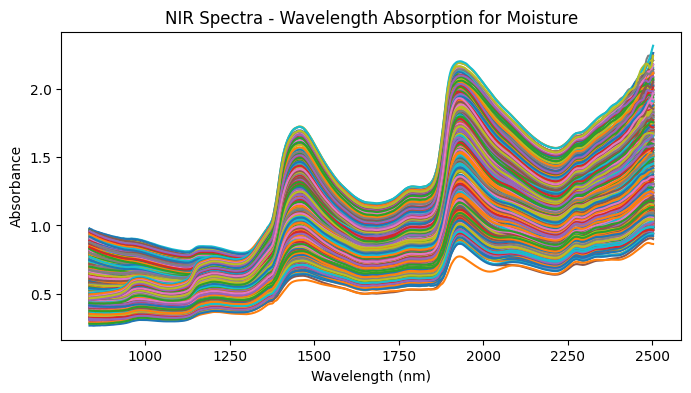

In [76]:
# Plot Spectra
plt.figure(figsize=(8, 4))
for spectrum in X:
    plt.plot(wavelengths, spectrum)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('NIR Spectra - Wavelength Absorption for Moisture')
plt.show()

In [32]:
# Apply Preprocessing
X_savgol = apply_savgol(X, window=11, poly=3, deriv=1)
X_snv = apply_snv(X)
X_msc = apply_msc(X)

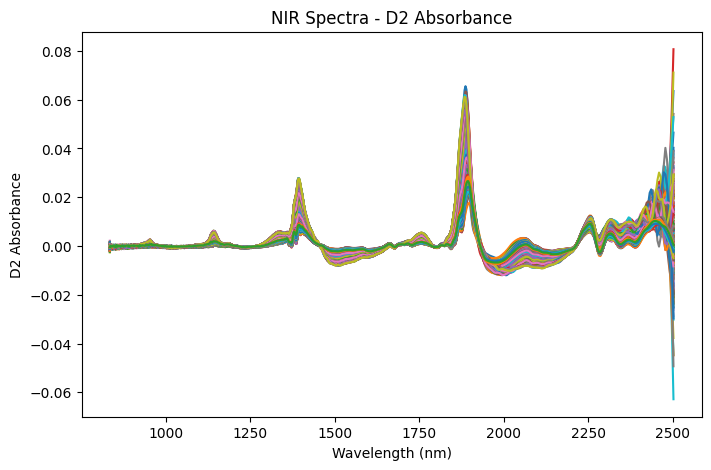

In [80]:
# Plot Spectra(SAVGOL)
plt.figure(figsize=(8, 5))
for spectrum in X_savgol:
    plt.plot(wavelengths, spectrum)

plt.xlabel('Wavelength (nm)')
plt.ylabel('D2 Absorbance')
plt.title('NIR Spectra - D2 Absorbance')
plt.show()

In [33]:
# Feature Selection
X_selected = feature_selection(X)

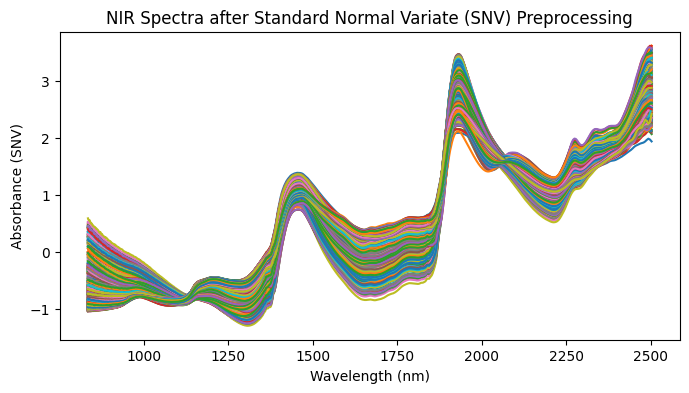

In [77]:
# Plot Spectra(SNV)
plt.figure(figsize=(8, 4))
for spectrum in X_snv:
    plt.plot(wavelengths, spectrum)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance (SNV)")
plt.title("NIR Spectra after Standard Normal Variate (SNV) Preprocessing")
plt.show()

In [35]:
# Train ML Models
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
# PLS Regression
pls_model, r2_pls, rmse_pls, y_pls_pred = train_model(
    X_selected, y, PLSRegression(),
    {'model__n_components': [5, 7, 10, 12]}, cv=cv
)

In [37]:
# Support Vector Regression (SVR)
svr_model, r2_svr, rmse_svr, y_svr_pred = train_model(
    X_selected, y, SVR(),
    {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}, cv=cv
)

In [53]:
ann_pipeline = Pipeline([
    ('msc', FunctionTransformer(apply_savgol)),
    ('scaler', StandardScaler()),
    ('ann', MLPRegressor(max_iter=1000, random_state=42))
])
ann_param_grid = {
    'ann__hidden_layer_sizes': [(50,), (100,), (100,50)],
    'ann__alpha': [0.0001, 0.001, 0.01],
    'ann__learning_rate_init': [0.0001, 0.001, 0.01]
}

def compute_metrics(y_true, y_pred):
    """Compute R² and RMSE."""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse


with tf.device('/GPU:0'):
  ann_grid = GridSearchCV(ann_pipeline, param_grid=ann_param_grid, cv=cv, scoring='r2', n_jobs=-1)
  ann_grid.fit(X, y)
print("ANN Best Parameters:", ann_grid.best_params_)

y_ann_pred = cross_val_predict(ann_grid.best_estimator_, X, y, cv=cv)
r2_ann, rmse_ann = compute_metrics(y, y_ann_pred)
print(f"ANN: R² = {r2_ann:.3f}, RMSE = {rmse_ann:.3f}")

ANN Best Parameters: {'ann__alpha': 0.01, 'ann__hidden_layer_sizes': (100, 50), 'ann__learning_rate_init': 0.001}
ANN: R² = 0.798, RMSE = 6.486


In [54]:
# Results
results = pd.DataFrame({
    "Model": ["PLS Regression", "SVR", "ANN"],
    "R²": [r2_pls, r2_svr, r2_ann],
    "RMSE": [rmse_pls, rmse_svr, rmse_ann]
})
print(results)

            Model        R²      RMSE
0  PLS Regression  0.958024  2.956238
1             SVR  0.905428  4.437336
2             ANN  0.797944  6.485998


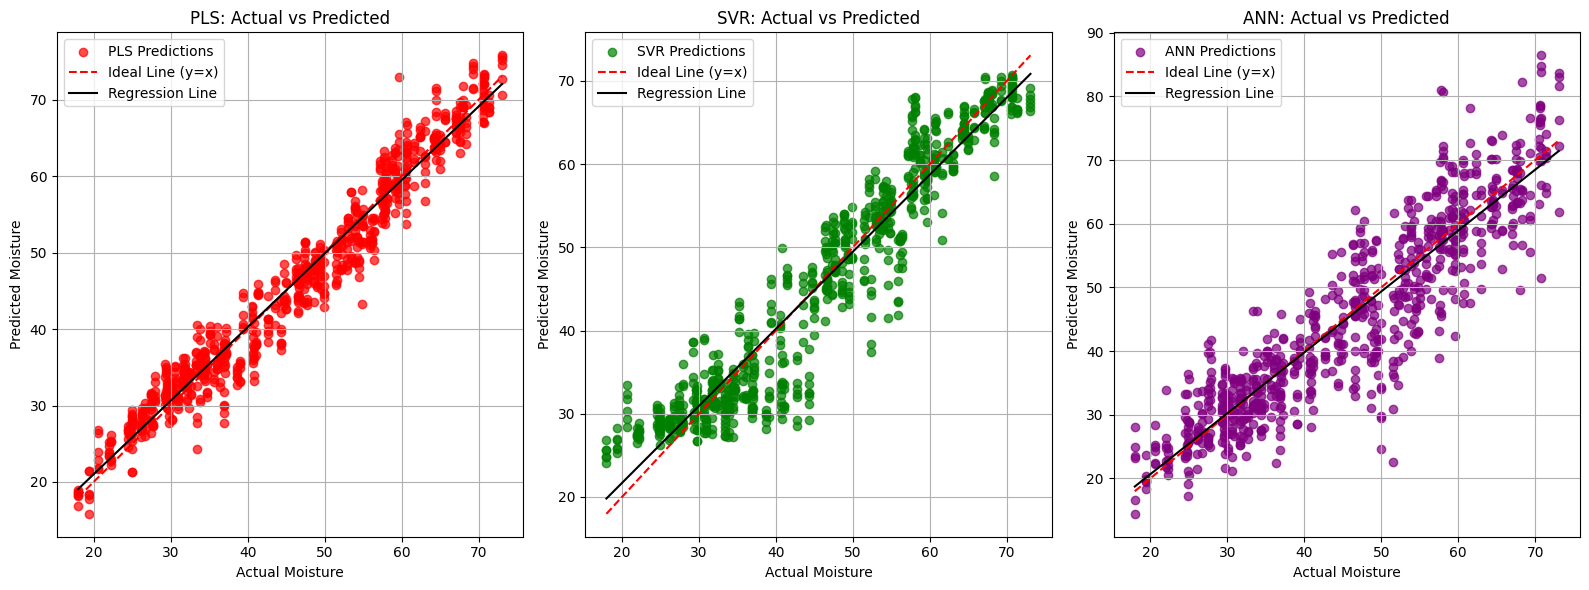

In [81]:
plt.figure(figsize=(16, 6))

models = ["PLS", "SVR", "ANN"]
predictions = [y_pls_pred, y_svr_pred, y_ann_pred]
colors = ['red', 'green', 'purple']

for i, (name, pred, color) in enumerate(zip(models, predictions, colors), 1):
    plt.subplot(1, 3, i)

    plt.scatter(y, pred, alpha=0.7, color=color, label=f'{name} Predictions')

    plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label="Ideal Line (y=x)")

    slope, intercept = np.polyfit(y, pred, 1)
    plt.plot([min(y), max(y)], [slope * min(y) + intercept, slope * max(y) + intercept], 'k-', label='Regression Line')

    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Moisture")
    plt.ylabel("Predicted Moisture")
    plt.legend()

    plt.grid(True)

plt.tight_layout()
plt.show()
